****
# **PREPROCESADO DE LOS DATOS (PALANQUILLAS CALIBRACIÓN)**
**NOTA:** las palanquillas de calibración son aquellas con identificador 6211341-6211358, pertenecientes a la familia de resulfurado. No confundir con la familia de calibradores.
****
**Autor**: Sergio Bolívar Gómez.

**Fecha**: 4 de abril de 2023.

## **IMPORTACIÓN DE LIBRERÍAS**

Importamos librerías que vamos a utilizar para el preprocesado de los datos de GSW:

In [19]:
import os # para interacturar con el sistema
import pandas as pd # para manejar DataFrames
import numpy as np # para manejar arrays y hacer operaciones sobre ellos
import matplotlib.pyplot as plt # para hacer gráficas
import seaborn as sns # para hacer gráficas mejores
import math # para hacer algunas operaciones
import glob # para aglutinar archivos
import copy # para hacer copias de objetos de Python
import pickle # para guardar diccionario de Python en ficheros

from scipy.interpolate import interp1d # para remuestrear señal
from datetime import datetime # para formatear fechas

In [20]:
# Para usar la fuente de LaTex en los plots
from matplotlib import rcParams
rcParams['text.usetex'] = True
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Computer Modern']

## **ALGUNAS FUNCIONES DE UTILIDAD**

In [21]:
def truncate(num, n):
    """
    Trunca el número que se pasa como parámetro al número de cifras especificado.

    PARÁMETROS:
    num (float): número que queremos truncar.
    n (int): número de cifras decimales que queremos mantener

    OUTPUT:
    float: número truncado

    EJEMPLO:
    >>> truncate(3.141592, 3)
    3.141
    """
    return float(int(num * (10**n))/(10**n))

In [22]:
def interpolate_punta(data):
    """
    Interpola los outliers en un array de datos utilizando interpolación lineal.
    
    PARÁMETROS:
    data (numpy.ndarray): array de datos con outliers
    
    OUTPUT:
    numpy.ndarray: array de datos sin outliers (eliminados mediante interpolación lineal)
    """
    while True:
        data = np.array(data)  # convierto los datos a un array de numpy para que no haya problemas de compatibilidad      
        outlier_indices = np.where((data < np.roll(data, 1)) | (data > np.roll(data, -1)))[0][1:-1] # buscamos los outliers (la secuencia es no decreciente)
        
        if len(outlier_indices) == 0: # el criterio de parada es que no haya outliers
            break
        
        # Interpolamos los outliers
        x = np.arange(len(data))
        interp_func = interp1d(x[np.logical_not(np.isin(x, outlier_indices))], data[np.logical_not(np.isin(x, outlier_indices))], kind='linear') # interpolación
        data[outlier_indices] = interp_func(outlier_indices) # sustituyo los outliers por sus valores interpolados

    return data


## **IMPORTACIÓN DE DATOS**

#### **INFORMACIÓN SOBRE LAS PALANQUILLAS (LONGITUD, DIÁMETRO, HILO, MATERIAL, CALIDAD...)**

In [23]:
# Creamos un diccionario que utilizaremos a modo de base de datos para almacenar INFORMACIÓN ADICIONAL sobre las palanquillas
info_palanquillas_db = {}

In [24]:
path_GSW_files = "/home/bolivars/Escritorio/data/raw/additional-info"  # CHANGEME: ruta que lleve a la información adicional de las palanquillas

file_pattern = os.path.join(path_GSW_files, "long_*.csv") # patrón útil para localizar los ficheros con información sobre las palanquillas (todos empienza por "long")
GSW_files = glob.glob(file_pattern) # lista con todos los ficheros proporcionados por GSW

info_to_store = ["long_punta", "long_cola", "diametro", "hilo", "material", "calidad"] # variables que representan la información que queremos almacenar

for GSW_data_file in GSW_files: # recorremos los ficheros proporcionados por GSW

    original_data = pd.read_csv(GSW_data_file, sep = ',', decimal = ".", # leemos los datos originales desde el CSV
                                usecols=lambda col: col != "Unnamed: 0"
                                ) # eliminamos la variable unnamed (basura)
    
    data_grouped_by_bulto = original_data.groupby('bulto') # agrupamos los datos según el bulto (identificador de la palanquilla)

    for name, group in data_grouped_by_bulto:

        palanquilla_info = {k: pd.DataFrame(group)[k].values[0] for k in info_to_store} # diccionario que contendrá la información especificada en la lista 'info_to_store'  

        info_palanquillas_db[name] = palanquilla_info # la key es el bulto de la palanquilla (identificador); el value el diccionario con toda la información

In [25]:
# EJEMPLO
info_palanquillas_db[6211341]

{'long_punta': 19.0819,
 'long_cola': 18.9171,
 'diametro': 44.0,
 'hilo': 1,
 'material': 'WAR1129440L000',
 'calidad': 'resulfurado_Pb'}

#### **SERIES TEMPORALES RELATIVAS AL CALENTAMIENTO DE LAS PALANQUILLAS**

In [26]:
# Creamos un diccionario que utilizaremos a modo de base de datos para almacenar toda la información relativa al CALENTAMIENTO de las palanquillas
palanquillas_db = {}

In [27]:
path_GSW_files = "/home/bolivars/Escritorio/data/raw/calibration"  # CHANGEME: ruta que lleve a los datos originales del hilo 1

file_pattern = os.path.join(path_GSW_files, "*df_to_ladicim_*.csv") # patrón que es útil para seleccionar todos los CSVs con datos originales
GSW_files = glob.glob(file_pattern) # lista con todos los ficheros proporcionados por GSW

data_to_store = ["original_data", "data_to_ansys", "data_to_ML", "first_measure", "last_measure"] # variables que representan la información que queremos almacenar

for GSW_data_file in GSW_files: # recorremos los ficheros proporcionados por GSW

    original_data = pd.read_csv(GSW_data_file, sep = ',', decimal = ".", # leemos los datos originales desde el CSV
                                parse_dates=['tiempo'], # identificamos la columna temporal
                                usecols=lambda col: col != "Unnamed: 0", # eliminamos la variable unnamed (basura)
                                na_values = "NaN" # identificamos los missing values
                                ).fillna(0) # sustituimos los NaN por 0s

    original_data["tiempo"] = pd.to_datetime(original_data['tiempo'], format='%Y.%m.%d %H:%M:%S.%f') #  formateamos la fecha para que no haya problemas de importación
    
    data_grouped_by_bulto = original_data.groupby('bulto') # agrupamos los datos según el bulto (identificador de la palanquilla)

    for name, group in data_grouped_by_bulto:

        palanquilla_data = {k: None for k in data_to_store + info_to_store} # diccionario que contendrá la información especificada en la lista 'data_to_store'

        original_data = pd.DataFrame(group).reset_index(drop=True)

        # Hay veces que tenemos valores nulos para la posición de la punta al final del dataset, los quito porque no tienen sentido (punta es creciente)
        delete_from_here = (original_data["punta"][::-1] > 0).idxmax()
        original_data.drop(original_data.index[original_data.index > delete_from_here], inplace=True)

        # Hay veces que tenemos temperaturas de salida nulas al final del dataset, estas medidas no interesan
        delete_from_here = (original_data["IF1 Pirometro salida horno"][::-1] > 0).idxmax()
        original_data.drop(original_data.index[original_data.index > delete_from_here], inplace=True) 

        palanquilla_data["original_data"] = original_data

        # palanquilla_data["original_data"] = pd.DataFrame(group).reset_index(drop=True) # sería así si no corregimos los valores nulos de la punta

        for item in info_to_store: # añado al diccionario global la información adicional sobre la palanquilla (longitud, material, hilo...)
            palanquilla_data[item] = info_palanquillas_db[name][item]
            
        palanquillas_db[name] = palanquilla_data # la key es el bulto de la palanquilla (identificador); el value el diccionario con toda la información

In [28]:
# EJEMPLO: variables almacenadas para cada palanquilla
palanquillas_db[6211341].keys()

dict_keys(['original_data', 'data_to_ansys', 'data_to_ML', 'first_measure', 'last_measure', 'long_punta', 'long_cola', 'diametro', 'hilo', 'material', 'calidad'])

In [29]:
# EJEMPLO: datos originales relativos a la palanquilla
palanquillas_db[6211341]["original_data"]

,bulto,IF1 Pirometro entrada horno,tiempo,IF1 Pirometro salida horno,IF1 Potencia actual inductor 1,IF1 Potencia actual inductor 2,IF1 Potencia actual inductor 3,IF1 Potencia actual inductor 4,punta
0,6211341,700.000,2022-08-05 08:54:28.105363,0.00,0.0,0.0,0.0,0.0,0.000000
1,6211341,702.120,2022-08-05 08:54:28.205363,0.00,0.0,0.0,0.0,0.0,0.000000
2,6211341,702.120,2022-08-05 08:54:28.305363,0.00,0.0,0.0,0.0,0.0,0.000000
3,6211341,867.499,2022-08-05 08:54:28.405363,0.00,0.0,0.0,0.0,0.0,0.250000
4,6211341,867.499,2022-08-05 08:54:28.505363,0.00,0.0,0.0,0.0,0.0,0.250000
...,...,...,...,...,...,...,...,...,...
1586,6211341,0.000,2022-08-05 08:57:06.405363,1074.97,0.0,0.0,0.0,766.0,39.127636
1587,6211341,0.000,2022-08-05 08:57:06.505363,1052.65,0.0,0.0,0.0,775.0,39.179736
1588,6211341,0.000,2022-08-05 08:57:06.605363,1052.65,0.0,0.0,0.0,775.0,39.179736
1589,6211341,0.000,2022-08-05 08:57:06.705363,1052.83,0.0,0.0,0.0,788.0,39.231436


In [30]:
# EJEMPLO: longitud de una palanquilla
palanquillas_db[6211341]["long_punta"]

19.0819

#### **REGISTRO DE LAS LAS PALANQUILLAS CONSIDERADAS EN EL ANÁLISIS**

In [31]:
print("El número de palanquillas consideradas es", len(palanquillas_db.keys()))

El número de palanquillas consideradas es 18


## **PREPROCESADO: CREANDO LOS INPUTS DE ANSYS + INPUTS DEL MODELO ML**

#### **PREPROCESADO DE LOS DATOS: RESAMPLING**

In [32]:
steps = 150 # menos de 200 porque si no da problemas de importación
num_steps = 200 # número de pasos de la simulación (tiene que ser un valor fijo, para poder meterlo como entrada de ANSYS)

path_ANSYS_files = "/home/bolivars/Escritorio/data/preprocessed/files-to-ansys" # CHANGEME: ruta que lleve a la carpeta donde queremos almacenar los inputs de ANSYS

if not os.path.exists(path_ANSYS_files): # si no existe el directorio, lo crea
    os.makedirs(path_ANSYS_files)

for palanquilla in sorted(palanquillas_db.keys()): # recorremos las palanquillas registradas en la base de datos

    print(f"PROCESANDO PALANQUILLA {palanquilla} ...")  
    
    original_data = palanquillas_db[palanquilla]["original_data"].copy() # cargamos datos originales relativos a la palaquilla

    # GUARDAMOS CONDICIONES DE CONTORNO
    inlet_temps = original_data["IF1 Pirometro entrada horno"]
    inlet_temp_mean_no_zero = np.mean(inlet_temps[inlet_temps != 0])

    bound_cond = pd.DataFrame({
    'temperatura_inicial': [inlet_temp_mean_no_zero], # la temperatura inicial es la media de la serie temporal del pirómetro de entrada
    'temperatura_aire': [800] # valor fijo
    }, index=[0])

    bound_cond_name = "cond_contorno_palanquilla_" + str(palanquilla)
    save_here = "%s/%s.csv" % (path_ANSYS_files, bound_cond_name)
    bound_cond.to_csv(save_here, sep=",", decimal = ".", index=False) # escribimos los datos en un CSV, que después será leído por ANSYS


    original_data["punta"] = interpolate_punta(original_data["punta"]) # hay veces que la punta se mide mal, interpolo sus valores

    first_measure = original_data['tiempo'][0] # fecha en la que se toma la primera medida (la palanquilla entra al horno)
    last_measure = original_data['tiempo'][len(original_data['tiempo'])-1] # fecha en la que se toma la última medida (la palanquilla sale del horno)

    original_data['tiempo'] = (original_data['tiempo'] - original_data['tiempo'][0]).dt.total_seconds() # pasamos de formato tiempo a segundos (escala absoluta)

    time_step = truncate(original_data['tiempo'].max()/steps, 2) # paso de tiempo (OJO! Estamos truncando y no llega al final!)

    time_window = np.array([0, time_step]) # tamaño de la ventana temporal
    
    initial_row = 0

    case_study = pd.DataFrame(columns=['tiempo', 'avance', 'velocidad', 'inlet_temp', 'IND_1', 'IND_2', 'IND_3', 'IND_4', 'outlet_temp']) # inicializamos un dataframe que contendrá los inputs para ANSYS

    for i in range (original_data.shape[0]):

        if original_data['tiempo'][i] > time_window[1]: # cuando el tiempo en los datos sea superior al extremo derecho del vector de la ventana temporal
            
            last_row = i

            new_data = {'tiempo': [max(original_data['tiempo'][initial_row:last_row])],
                        'avance': original_data['punta'][last_row]-original_data['punta'][initial_row],
                        'velocidad': (original_data['punta'][last_row]-original_data['punta'][initial_row])/(original_data['tiempo'][last_row]-original_data['tiempo'][initial_row]),
                        'inlet_temp': original_data['IF1 Pirometro entrada horno'][initial_row:last_row].mean(), 
                        'IND_1':  original_data['IF1 Potencia actual inductor 1'][initial_row:last_row].mean(), 
                        'IND_2':  original_data['IF1 Potencia actual inductor 2'][initial_row:last_row].mean(), 
                        'IND_3':  original_data['IF1 Potencia actual inductor 3'][initial_row:last_row].mean(), 
                        'IND_4':  original_data['IF1 Potencia actual inductor 4'][initial_row:last_row].mean(),                        
                        'outlet_temp': original_data['IF1 Pirometro salida horno'][initial_row:last_row].mean()
                        }     

            case_study = pd.concat([case_study, pd.DataFrame(data=new_data, columns = case_study.columns)], ignore_index=True) # concatenamos (por filas) los nuevos datos

            # Actualización de la ventana temporal
            initial_row = last_row
            time_window[0] = original_data['tiempo'][initial_row-1]
            time_window[1] = time_window[0] + time_step
            
            # OTRA OPCIÓN
            # time_window[0] += time_step
            # time_window[1] += time_step

    else: # si no hago esto, no llega hasta el final por el truncamiento del time step

        if case_study['tiempo'].max() < original_data['tiempo'].max():
            new_data = {'tiempo': [max(original_data['tiempo'][initial_row:])],
                        'avance': original_data['punta'].max()-original_data['punta'][initial_row],
                        'velocidad': case_study["velocidad"].iloc[-1],
                        'inlet_temp': original_data['IF1 Pirometro entrada horno'][initial_row:].mean(), 
                        'IND_1':  original_data['IF1 Potencia actual inductor 1'][initial_row:].mean(), 
                        'IND_2':  original_data['IF1 Potencia actual inductor 2'][initial_row:].mean(), 
                        'IND_3':  original_data['IF1 Potencia actual inductor 3'][initial_row:].mean(), 
                        'IND_4':  original_data['IF1 Potencia actual inductor 4'][initial_row:].mean(),                        
                        'outlet_temp': original_data['IF1 Pirometro salida horno'][initial_row:].mean()
                        }
            case_study = pd.concat([case_study, pd.DataFrame(data=new_data, columns = case_study.columns)], ignore_index=True) # concatenamos (por filas) los nuevos datos


    instances_to_fill = num_steps - len(case_study) # número de observaciones/instancias a rellenar con 0s para llegar a num_steps

    for j in range(instances_to_fill): # rellenamos hasta que el número de observaciones sea igual a num_steps (APDL requiere entrada de tamaño fijo)
        new_data = {'tiempo': [max(case_study['tiempo']) + 0.001],
                    'avance': 0, 
                    'velocidad': 0,
                    'inlet_temp': 0,
                    'IND_1':  0, 
                    'IND_2':  0, 
                    'IND_3':  0, 
                    'IND_4':  0,
                    'outlet_temp': 0
                    } 
        case_study = pd.concat([case_study, pd.DataFrame(data=new_data, columns = case_study.columns)], ignore_index=True) # concatenamos (por filas) los nuevos datos

    case_study['posicion'] = case_study['avance'].cumsum() # creamos una nueva variable que indica la posición 

    #### FASE DE LIMPIEZA ####

    case_study.loc[(case_study["posicion"] > palanquillas_db[palanquilla]["long_punta"]), "inlet_temp"] = 0 # elimino registros de entrada por encima de la variable 'long_punta'
    case_study.loc[(case_study["posicion"] < palanquillas_db[palanquilla]["long_cola"]), "outlet_temp"] = 0 # elimino registros de salida por debajo de la variable 'long_cola'

    # Escribimos los ficheros en un archivo   
    case_study_name = "caso_estudio_palanquilla_" + str(palanquilla)
    save_here = "%s/%s.csv" % (path_ANSYS_files, case_study_name)
    case_study.to_csv(save_here, sep=",", decimal = ".", index=False) # escribimos los datos en un CSV, que después será leído por ANSYS

    # Guardamos la información relativa a la palanquilla en la base de datos
    palanquillas_db[palanquilla]["data_to_ansys"] = case_study
    palanquillas_db[palanquilla]["data_to_ML"] = case_study.drop(index=range(len(case_study)-instances_to_fill, len(case_study)))
    palanquillas_db[palanquilla]["first_measure"] = first_measure
    palanquillas_db[palanquilla]["last_measure"] = last_measure

    print("  El tamaño del dataset original es", palanquillas_db[palanquilla]["original_data"].shape)
    print("  El tamaño del input para ANSYS es", palanquillas_db[palanquilla]["data_to_ansys"].shape)
    print("  El tamaño del input para el modelo ML es", palanquillas_db[palanquilla]["data_to_ML"].shape)
    print("  Timestamp de la primera medida:", palanquillas_db[palanquilla]["first_measure"])
    print("  Timestamp de la última medida:", palanquillas_db[palanquilla]["last_measure"])
    print("  Última posición de la punta (originales):", palanquillas_db[palanquilla]["original_data"]["punta"].iloc[-1])
    print("  Última posición de la punta (tratados):", palanquillas_db[palanquilla]["data_to_ML"]["posicion"].iloc[-1], "\n")

PROCESANDO PALANQUILLA 6211341 ...


  El tamaño del dataset original es (1591, 9)
  El tamaño del input para ANSYS es (200, 10)
  El tamaño del input para el modelo ML es (159, 10)
  Timestamp de la primera medida: 2022-08-05 08:54:28.105363
  Timestamp de la última medida: 2022-08-05 08:57:06.805363
  Última posición de la punta (originales): 39.231436000000045
  Última posición de la punta (tratados): 39.231436000000045 

PROCESANDO PALANQUILLA 6211342 ...
  El tamaño del dataset original es (1583, 9)
  El tamaño del input para ANSYS es (200, 10)
  El tamaño del input para el modelo ML es (158, 10)
  Timestamp de la primera medida: 2022-08-05 08:56:19.605363
  Timestamp de la última medida: 2022-08-05 08:58:57.605363
  Última posición de la punta (originales): 39.121664
  Última posición de la punta (tratados): 39.121664 

PROCESANDO PALANQUILLA 6211343 ...
  El tamaño del dataset original es (1523, 9)
  El tamaño del input para ANSYS es (200, 10)
  El tamaño del input para el modelo ML es (152, 10)
  Timestamp de la p

#### **COMPROBANDO LOS RESULTADOS OBTENIDOS**

In [33]:
# EJEMPLO
original_data = palanquillas_db[6211341]["original_data"].copy()
original_data['tiempo'] = (original_data['tiempo'] - original_data['tiempo'][0]).dt.total_seconds()

data_to_ansys = palanquillas_db[6211341]["data_to_ansys"].copy()
data_to_ML = palanquillas_db[6211341]["data_to_ML"].copy()

In [34]:
original_data

,bulto,IF1 Pirometro entrada horno,tiempo,IF1 Pirometro salida horno,IF1 Potencia actual inductor 1,IF1 Potencia actual inductor 2,IF1 Potencia actual inductor 3,IF1 Potencia actual inductor 4,punta
0,6211341,700.000,0.0,0.00,0.0,0.0,0.0,0.0,0.000000
1,6211341,702.120,0.1,0.00,0.0,0.0,0.0,0.0,0.000000
2,6211341,702.120,0.2,0.00,0.0,0.0,0.0,0.0,0.000000
3,6211341,867.499,0.3,0.00,0.0,0.0,0.0,0.0,0.250000
4,6211341,867.499,0.4,0.00,0.0,0.0,0.0,0.0,0.250000
...,...,...,...,...,...,...,...,...,...
1586,6211341,0.000,158.3,1074.97,0.0,0.0,0.0,766.0,39.127636
1587,6211341,0.000,158.4,1052.65,0.0,0.0,0.0,775.0,39.179736
1588,6211341,0.000,158.5,1052.65,0.0,0.0,0.0,775.0,39.179736
1589,6211341,0.000,158.6,1052.83,0.0,0.0,0.0,788.0,39.231436


In [35]:
data_to_ansys

,tiempo,avance,velocidad,inlet_temp,IND_1,IND_2,IND_3,IND_4,outlet_temp,posicion
0,1.000,1.0000,0.909091,864.863182,0.0,0.0,0.0,0.0,0.0,1.000000
1,2.000,1.0000,1.000000,1023.491000,0.0,0.0,0.0,0.0,0.0,2.000000
2,3.000,1.0000,1.000000,1042.019000,102.6,0.0,0.0,0.0,0.0,3.000000
3,4.000,0.9875,0.987500,1036.705000,342.7,0.0,0.0,0.0,0.0,3.987500
4,5.000,0.6519,0.651900,1043.246000,339.3,0.0,0.0,0.0,0.0,4.639400
...,...,...,...,...,...,...,...,...,...,...
195,158.737,0.0000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,39.231436
196,158.738,0.0000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,39.231436
197,158.739,0.0000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,39.231436
198,158.740,0.0000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,39.231436


In [36]:
data_to_ML

,tiempo,avance,velocidad,inlet_temp,IND_1,IND_2,IND_3,IND_4,outlet_temp,posicion
0,1.0,1.0000,0.909091,864.863182,0.0,0.0,0.0,0.000000,0.000000,1.000000
1,2.0,1.0000,1.000000,1023.491000,0.0,0.0,0.0,0.000000,0.000000,2.000000
2,3.0,1.0000,1.000000,1042.019000,102.6,0.0,0.0,0.000000,0.000000,3.000000
3,4.0,0.9875,0.987500,1036.705000,342.7,0.0,0.0,0.000000,0.000000,3.987500
4,5.0,0.6519,0.651900,1043.246000,339.3,0.0,0.0,0.000000,0.000000,4.639400
...,...,...,...,...,...,...,...,...,...,...
154,155.0,0.2075,0.207500,0.000000,0.0,0.0,0.0,717.000000,1050.455000,38.505236
155,156.0,0.2074,0.207400,0.000000,0.0,0.0,0.0,835.000000,1059.165000,38.712636
156,157.0,0.2075,0.207500,0.000000,0.0,0.0,0.0,800.800000,1067.853000,38.920136
157,158.0,0.2075,0.207500,0.000000,0.0,0.0,0.0,768.100000,1075.717000,39.127636


## **COMPARACIÓN DE DATOS: ORIGINALES VS. TRATADOS**

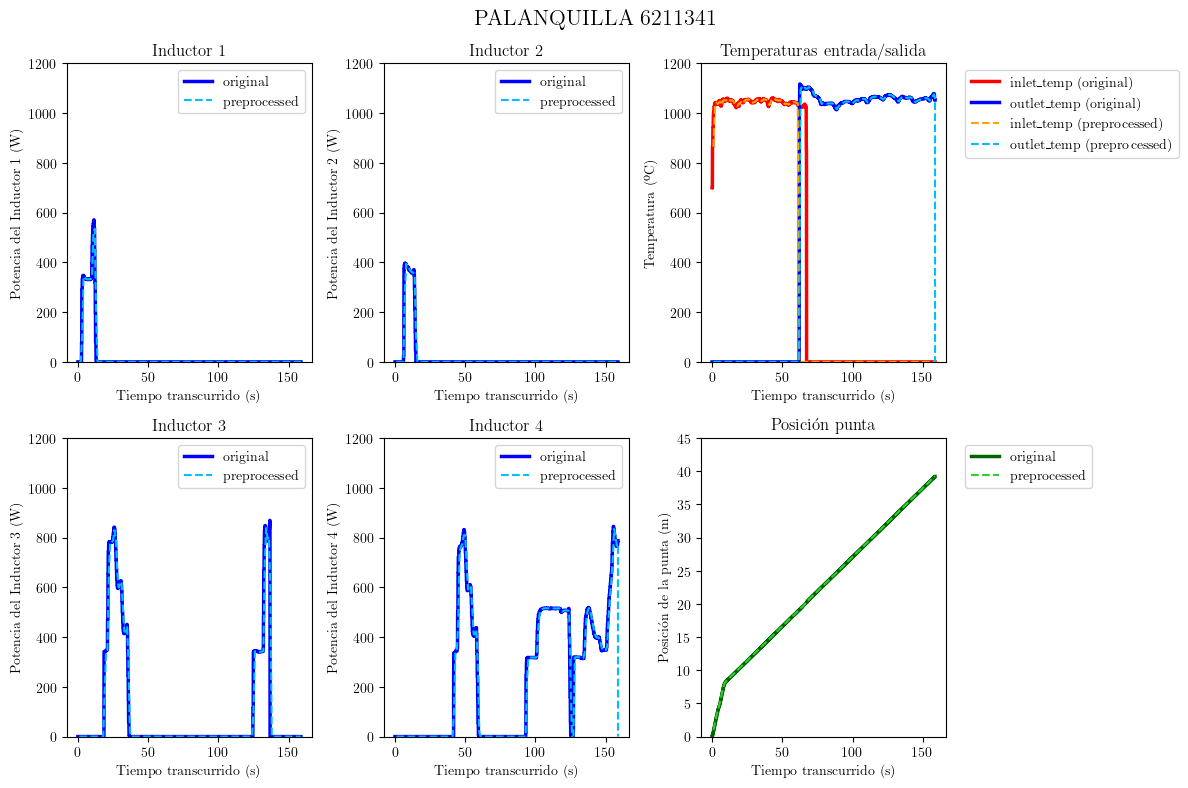

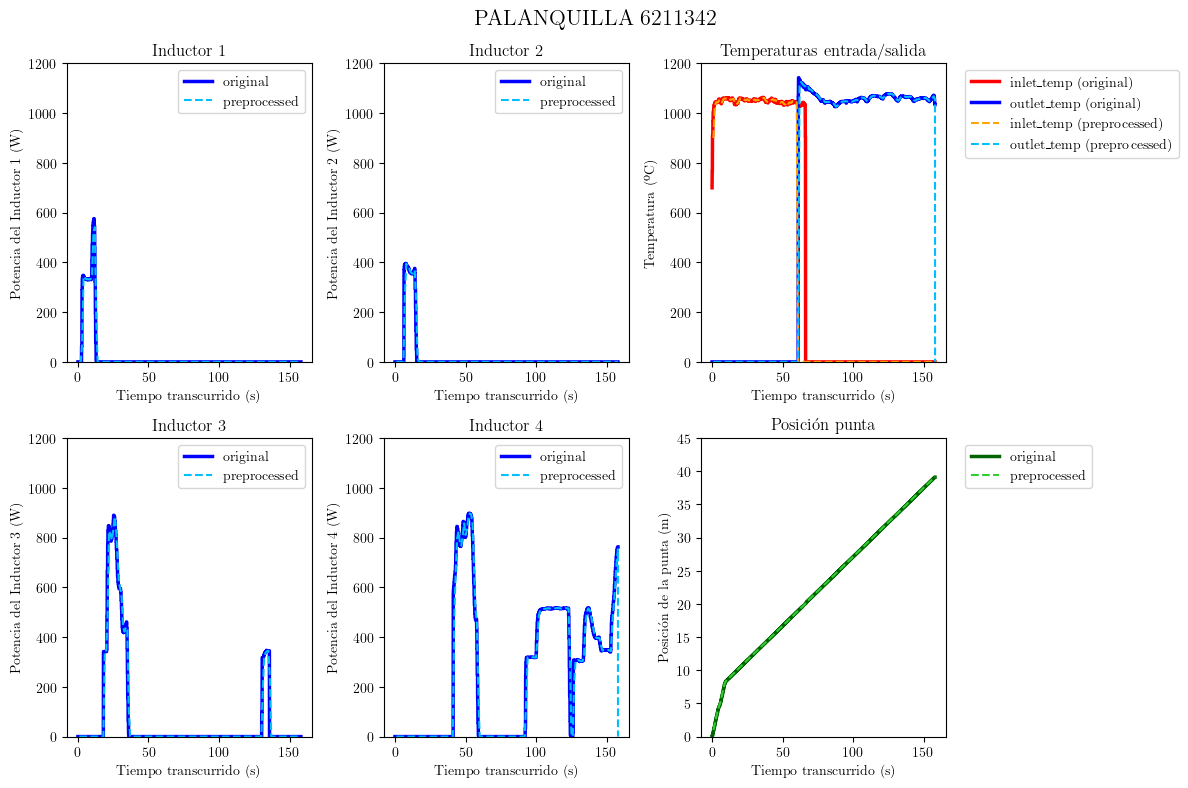

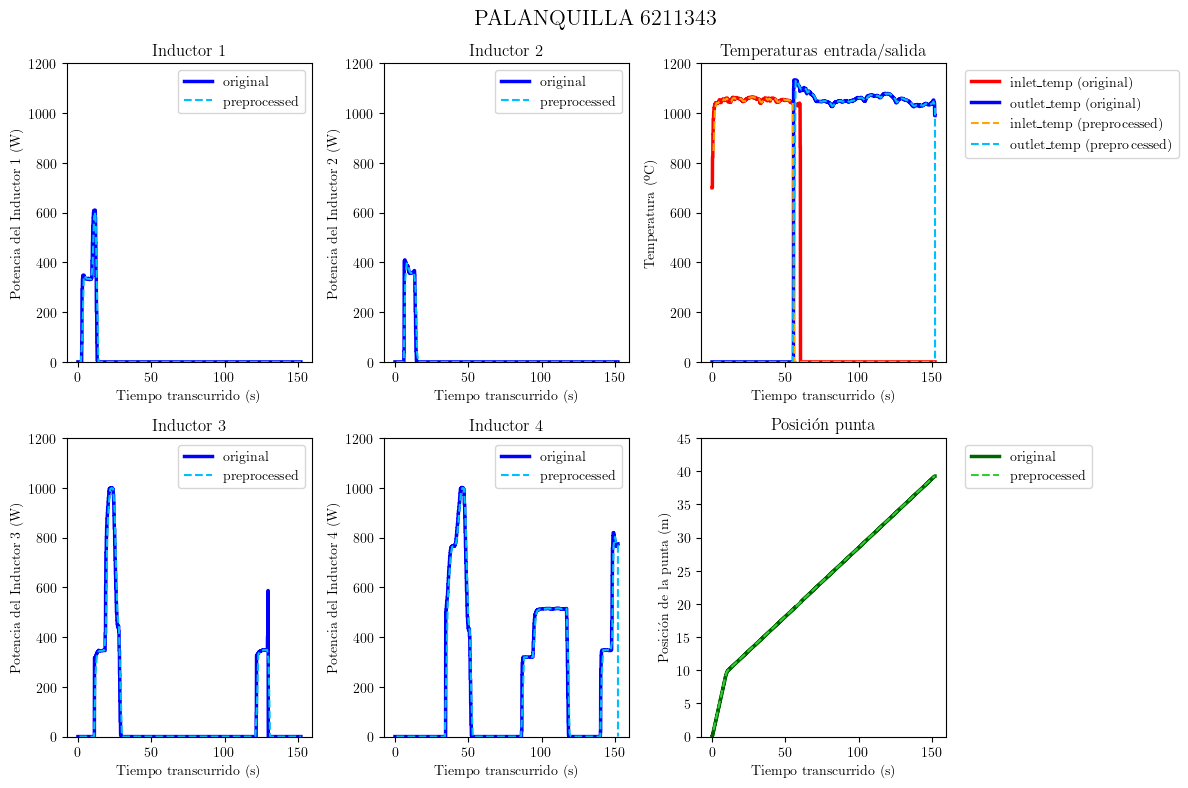

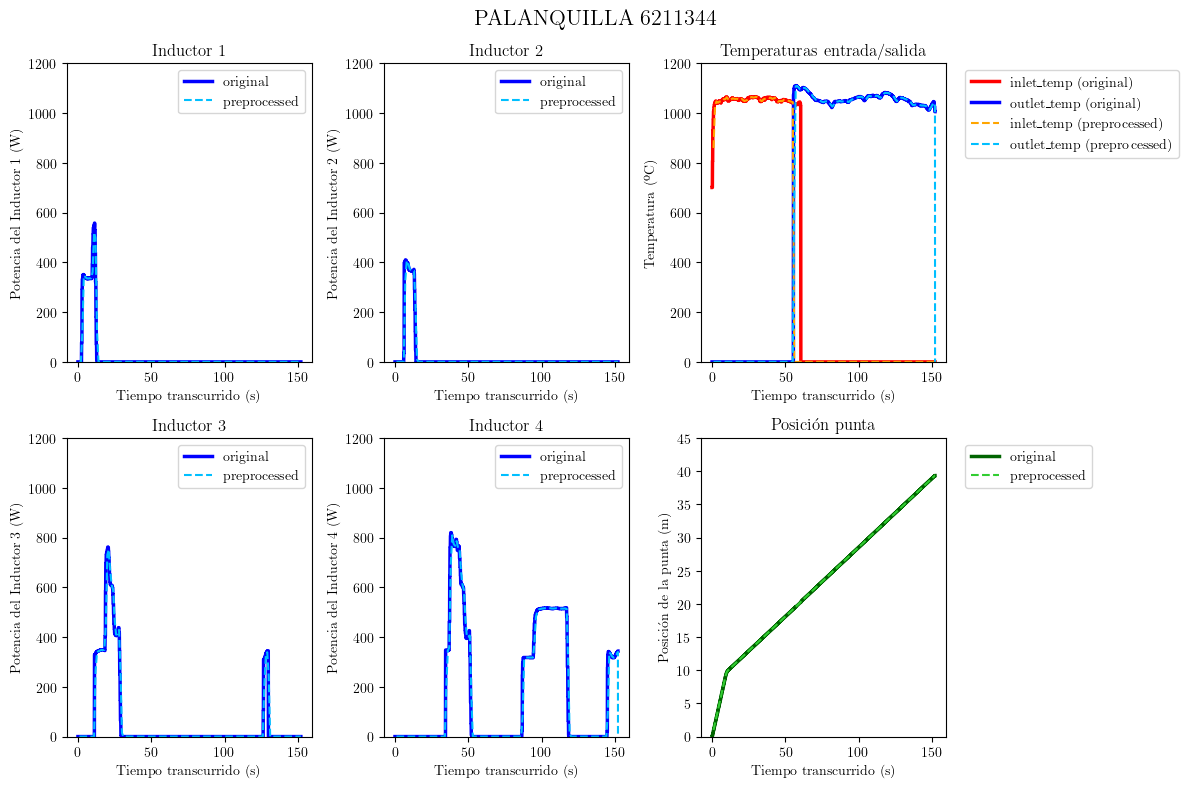

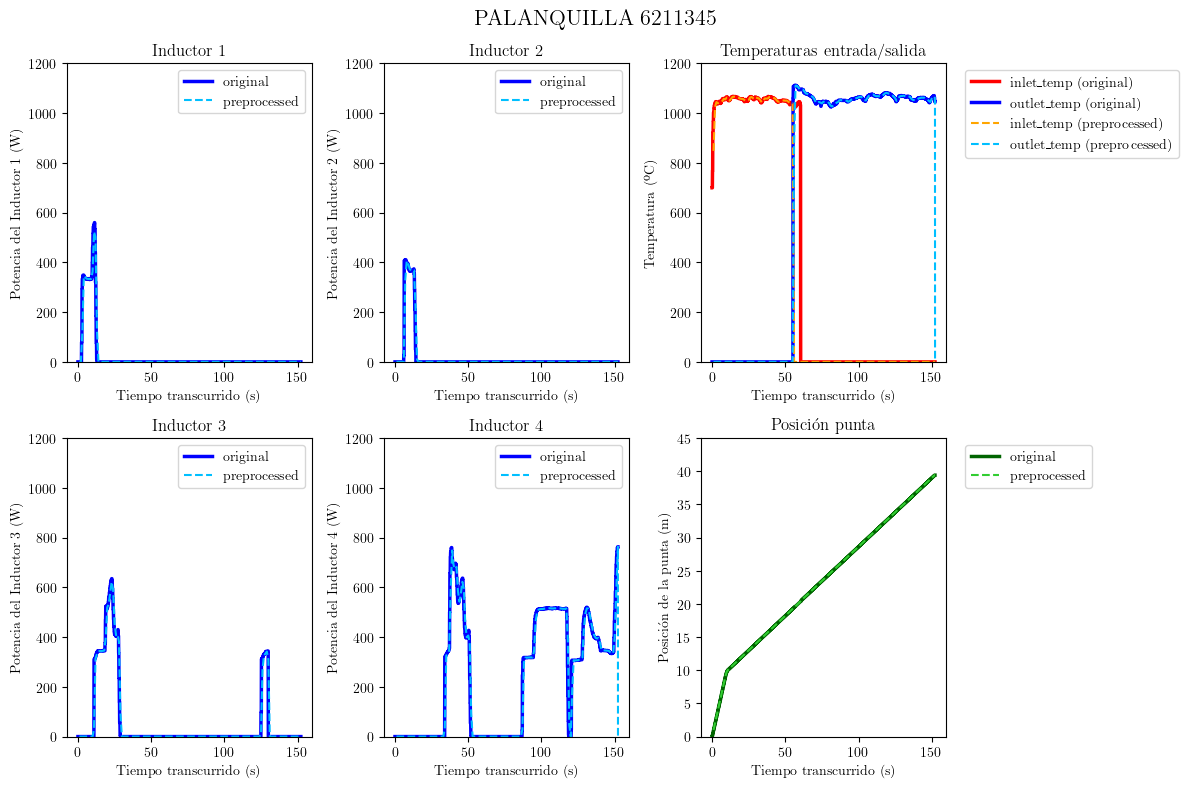

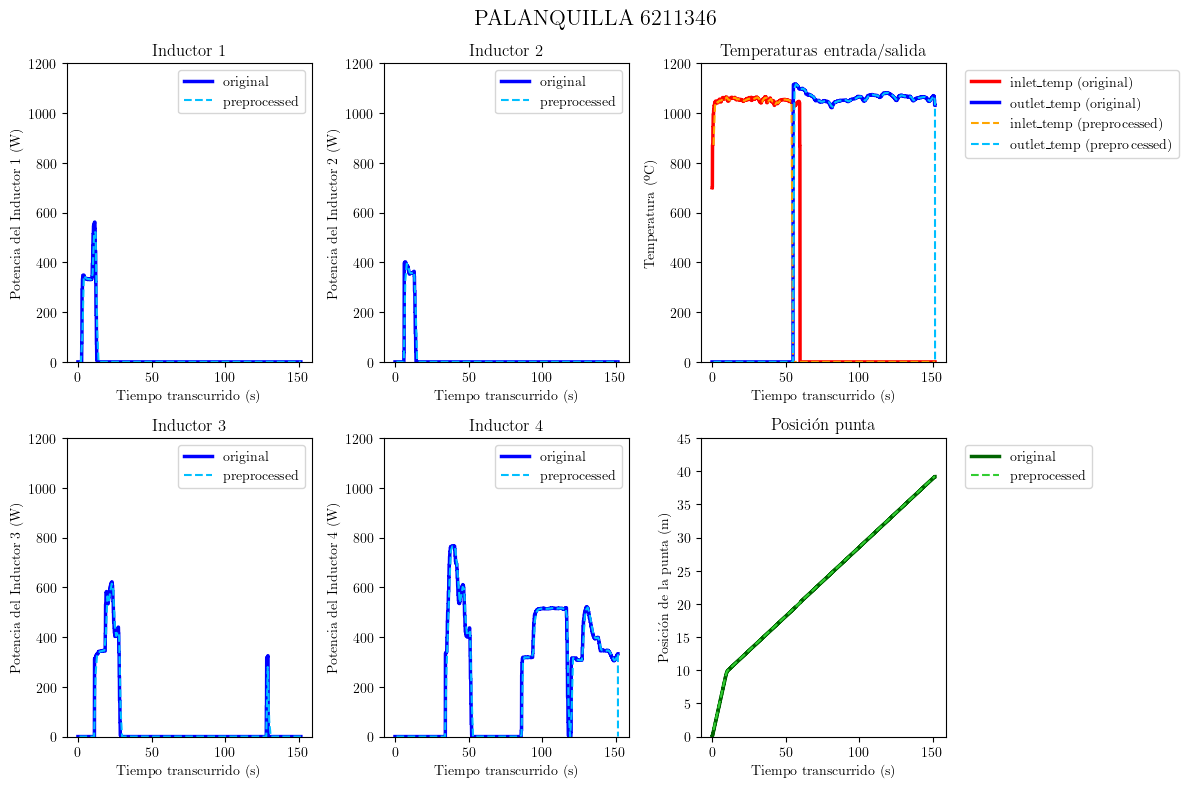

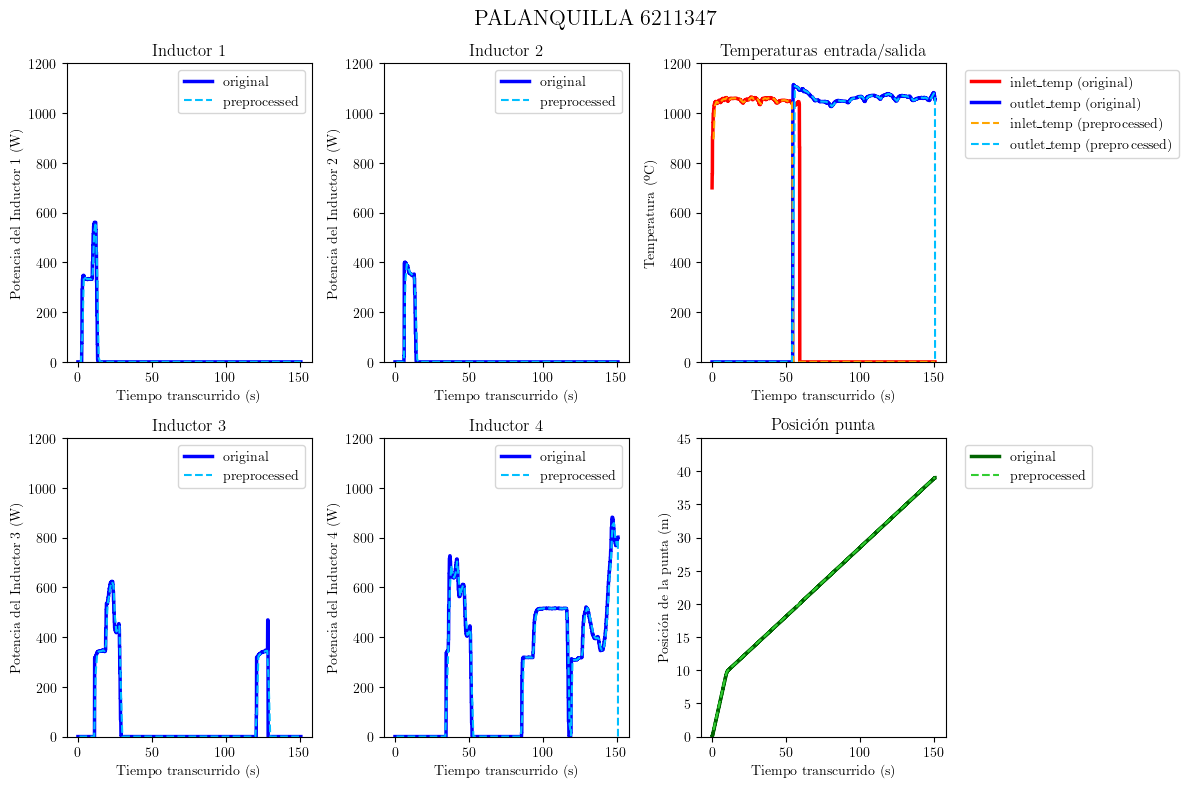

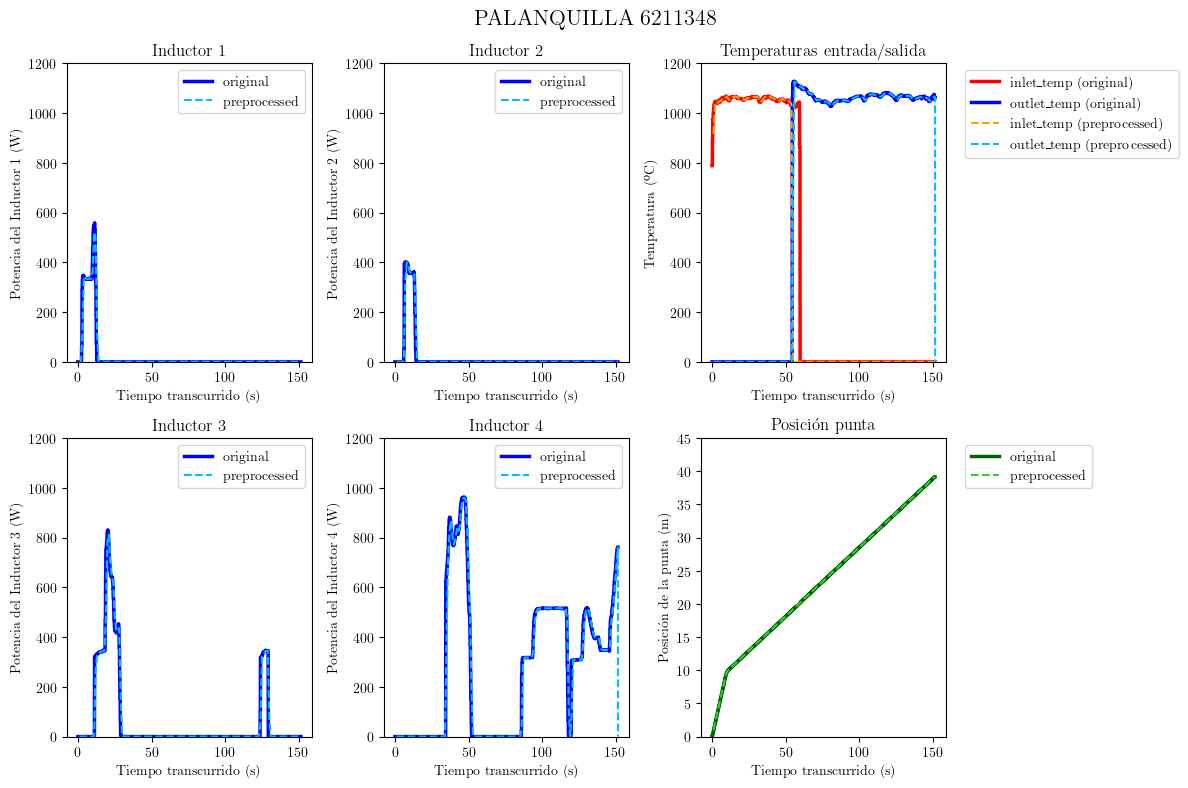

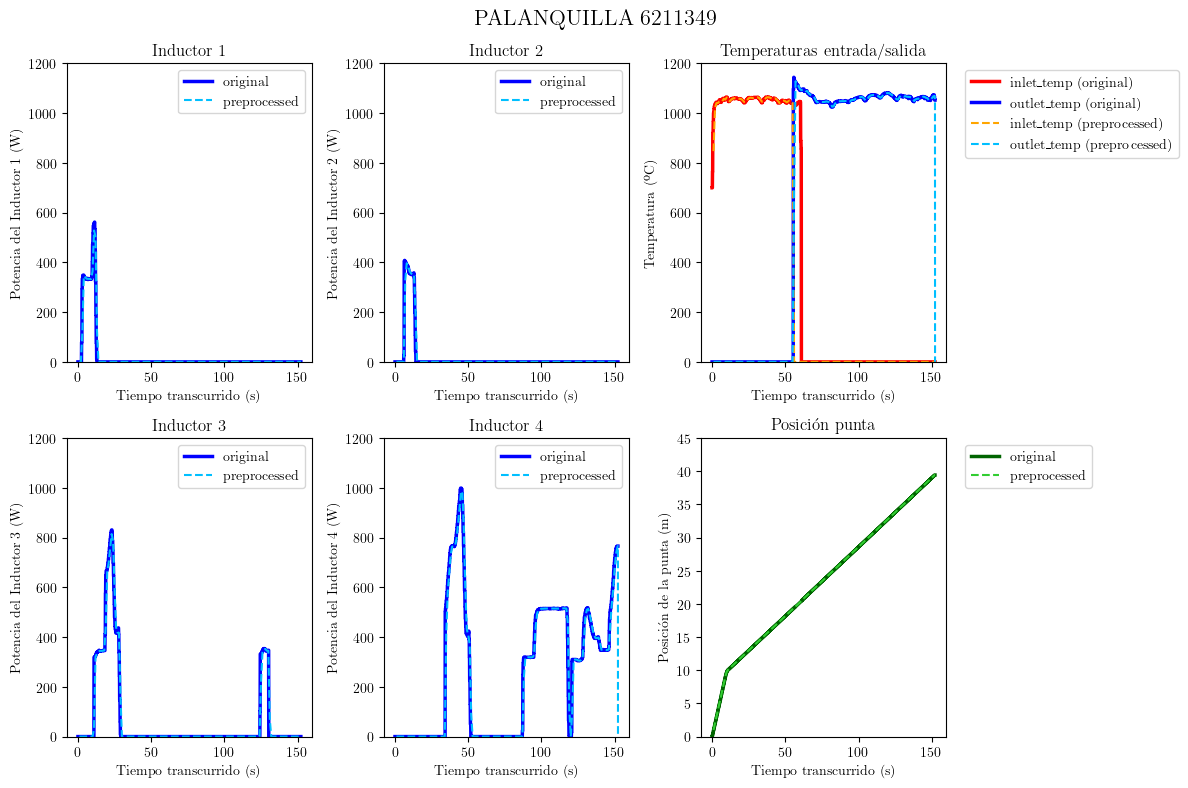

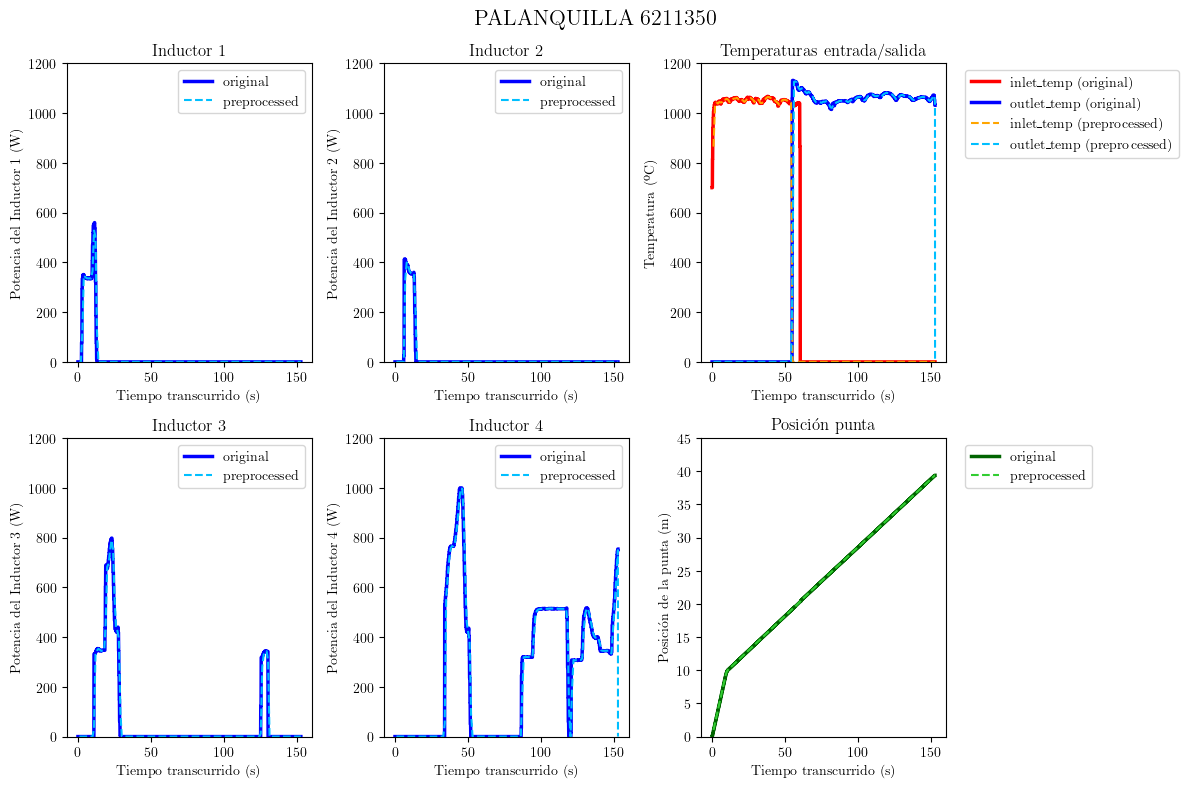

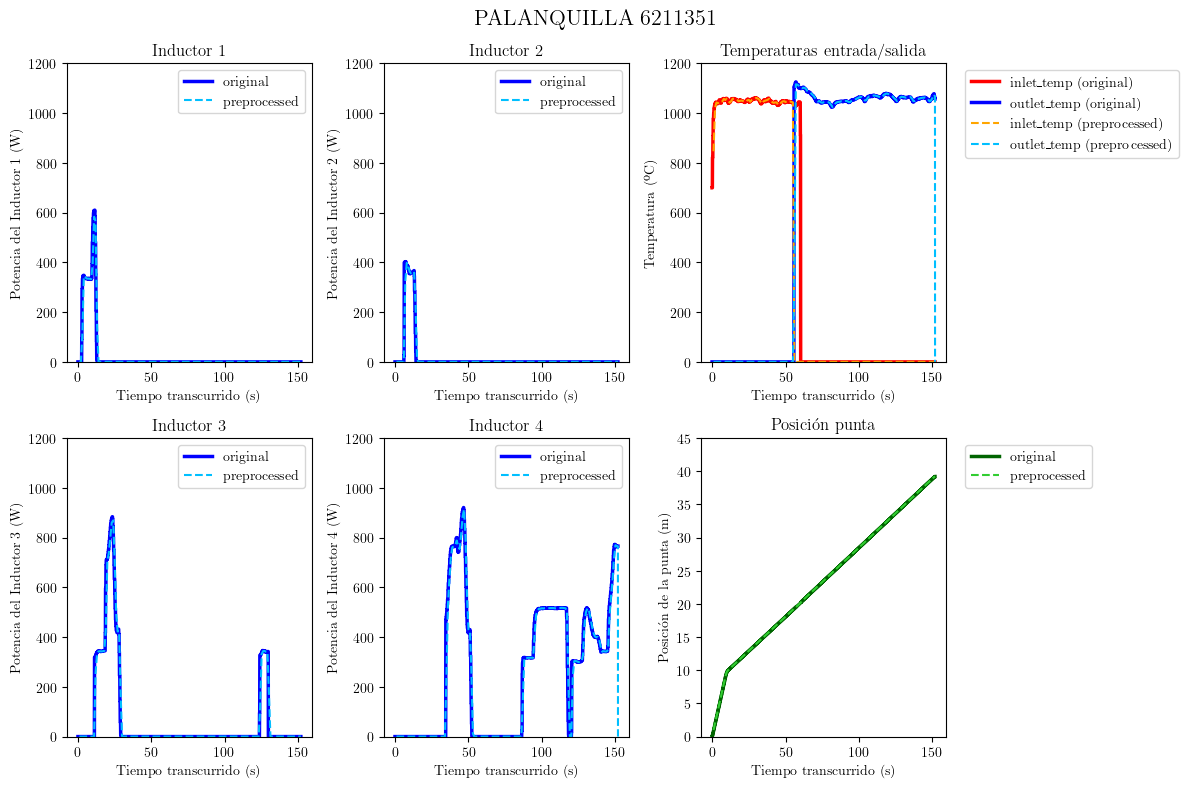

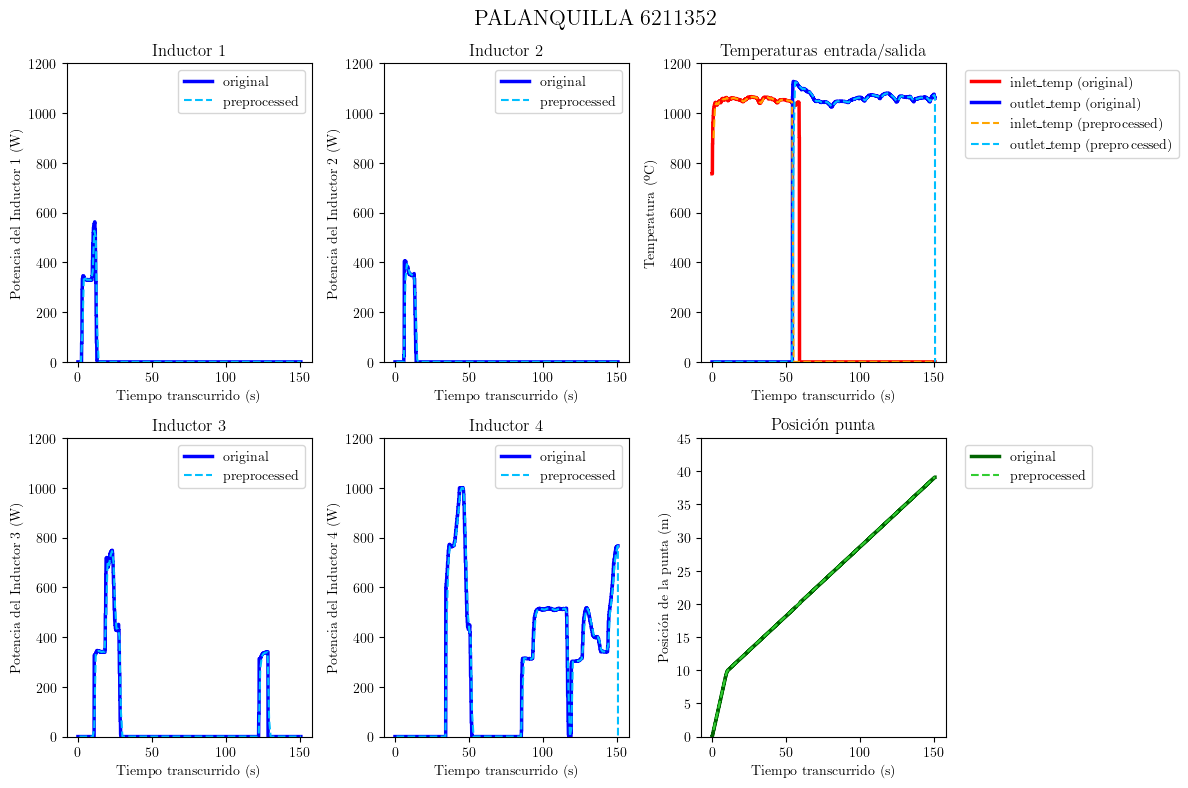

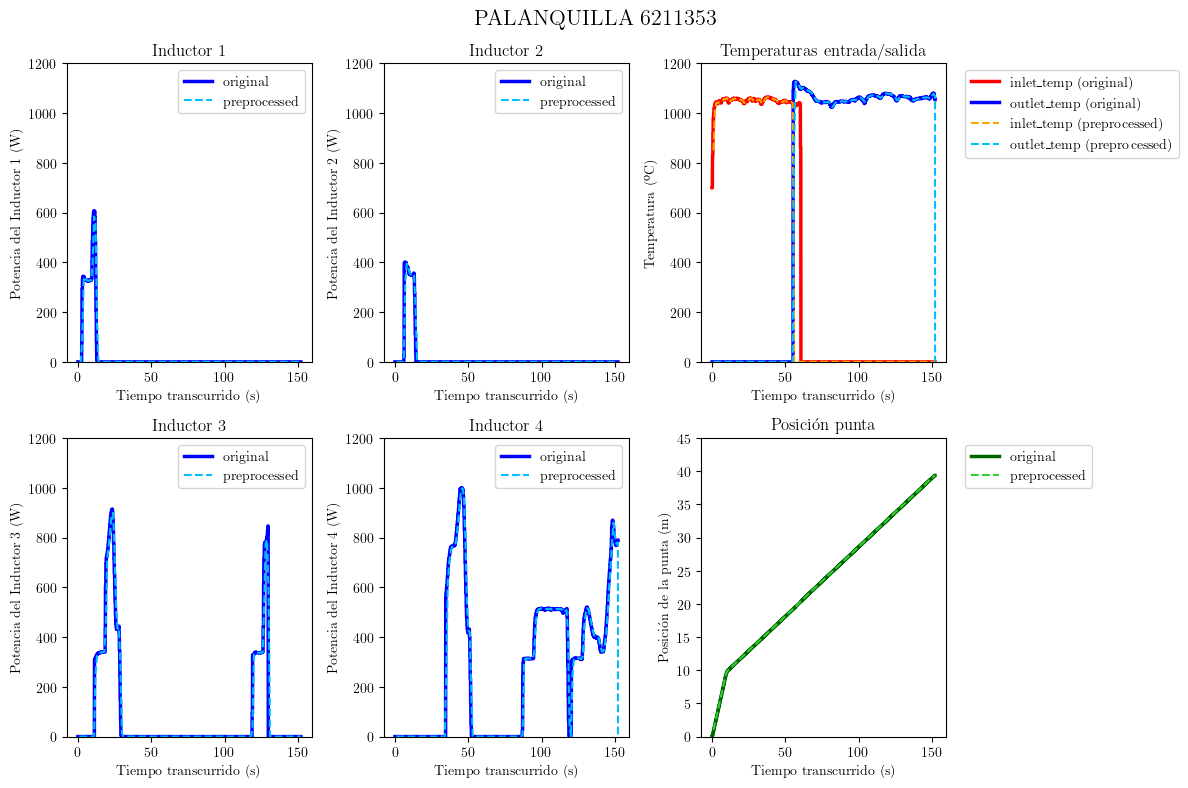

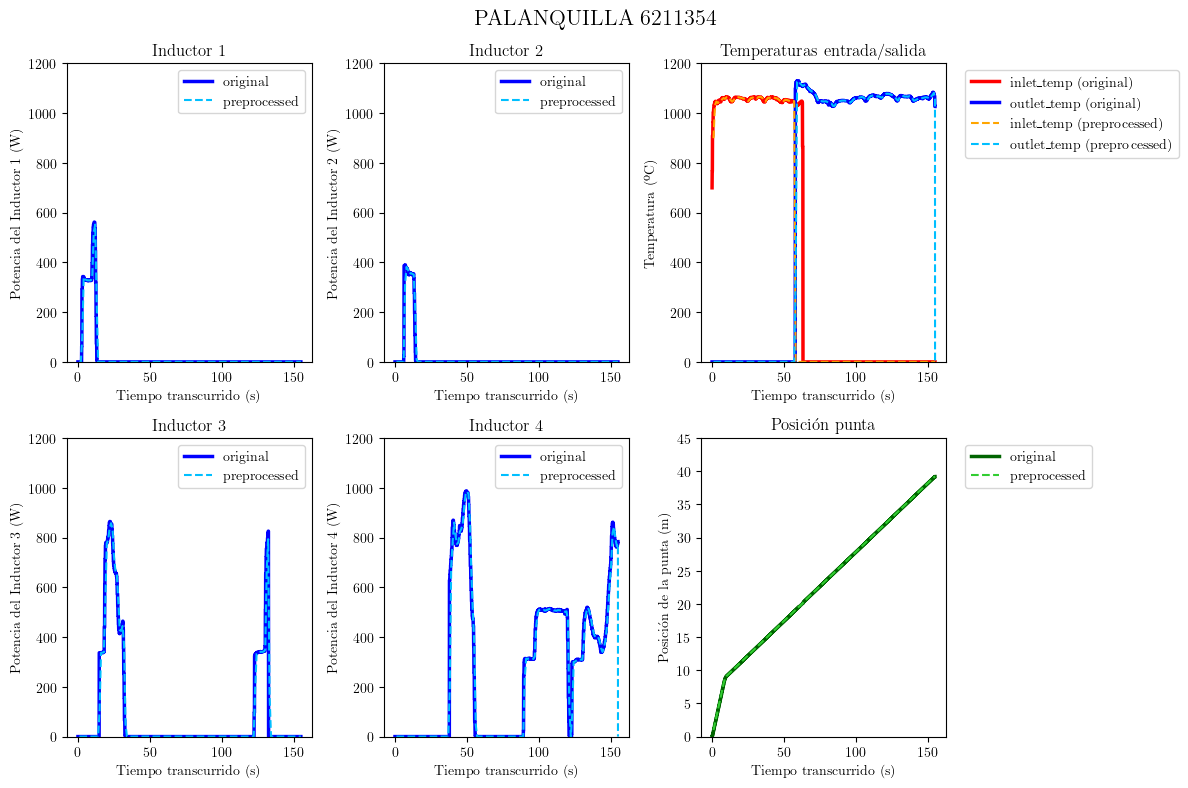

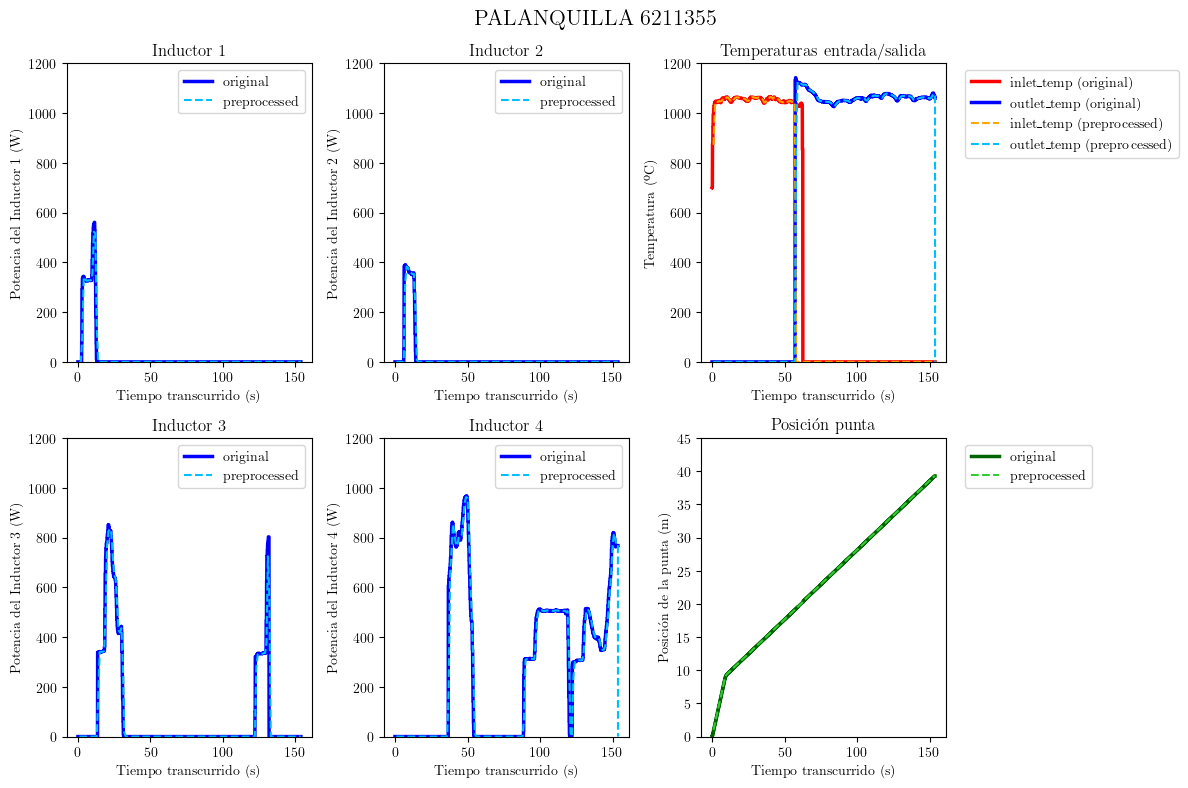

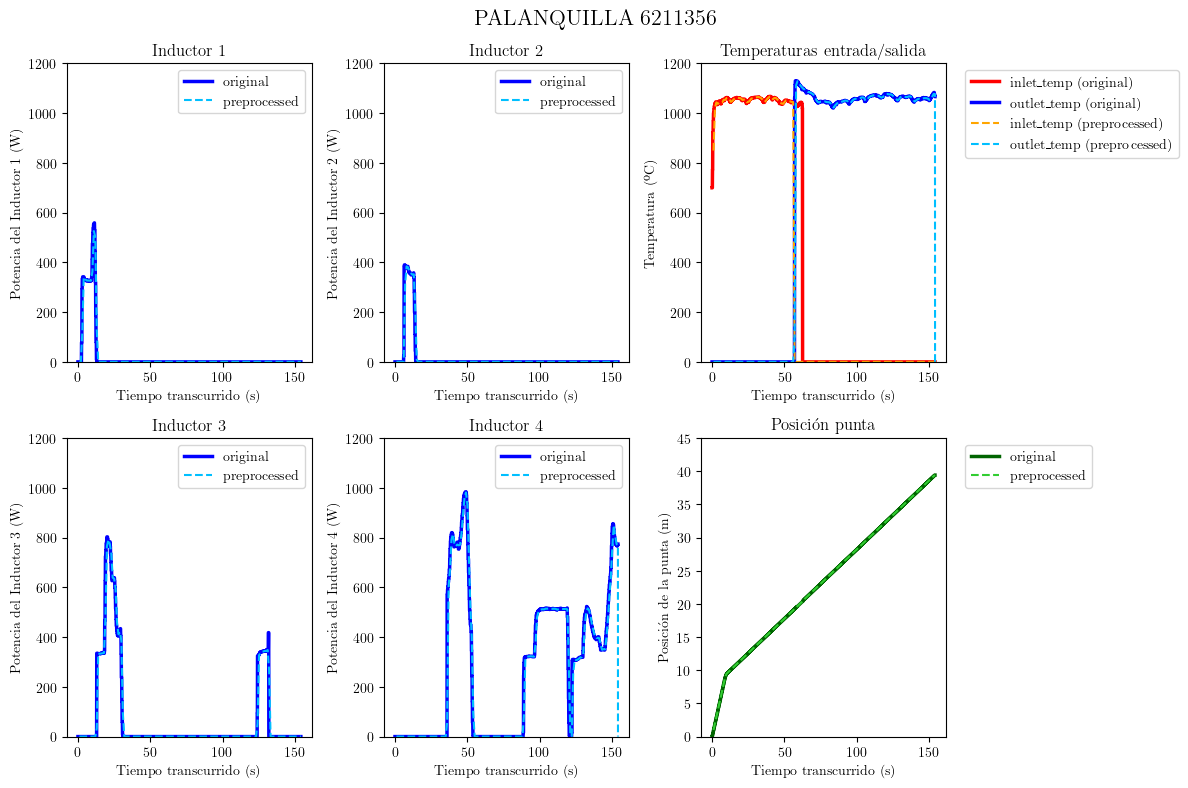

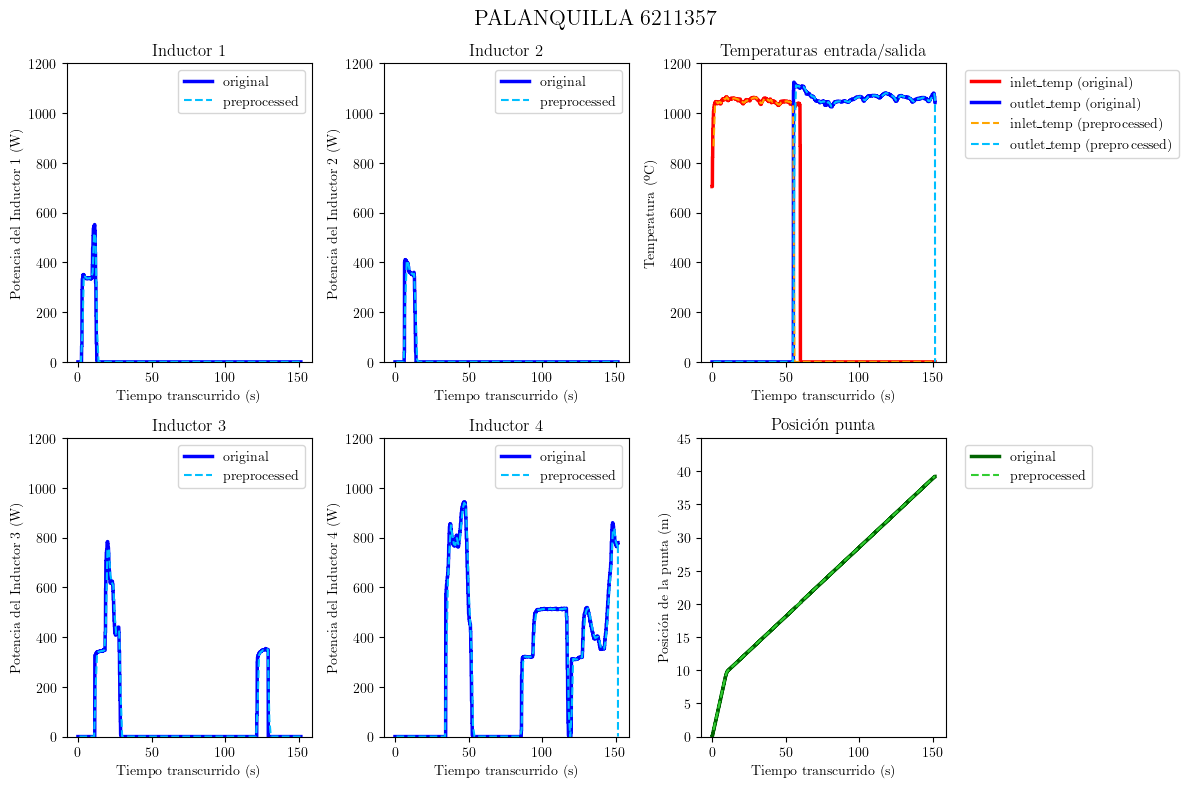

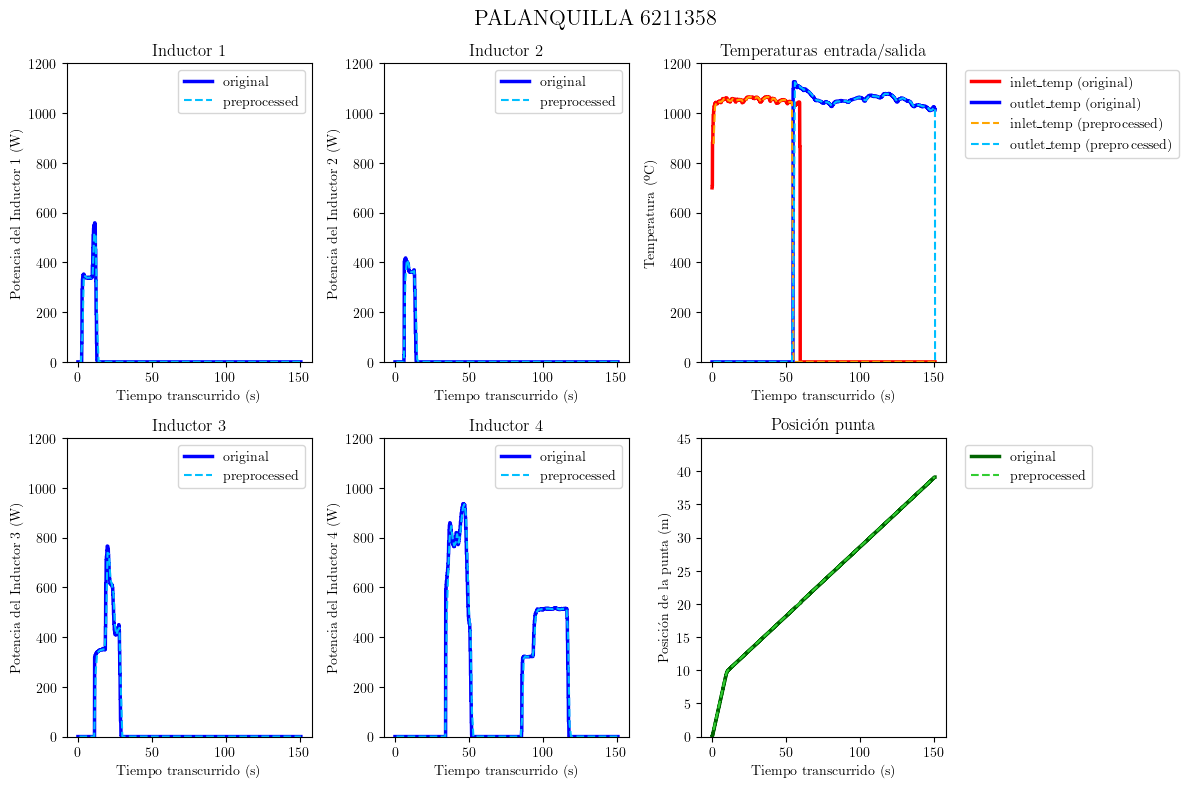

In [37]:
for palanquilla in sorted(list(palanquillas_db.keys())):
   
    # CARGADO DE DATOS
    original_data = palanquillas_db[palanquilla]["original_data"].copy()
    preprocessed_data = palanquillas_db[palanquilla]["data_to_ansys"].copy()

    # Necesario para poder hacer la comparativa, pues en "original_data", el tiempo está en formato "datetime"
    original_data['tiempo'] = (original_data['tiempo'] - original_data['tiempo'][0]).dt.total_seconds()

    # CONSTRUIMOS LA GŔAFICA

    fig = plt.figure(figsize=(12, 8))

    plt.suptitle(f"PALANQUILLA {palanquilla}", fontsize=16, fontweight='bold', ha='center')

    # Plot 1: POTENCIA INDUCTOR 1 VS. TIEMPO
    plt.subplot(2, 3, 1)

    plt.plot(original_data['tiempo'], original_data['IF1 Potencia actual inductor 1'], label = "original", linewidth=2.5, color = "blue", alpha = 1)
    plt.plot(preprocessed_data['tiempo'],preprocessed_data['IND_1'], label = "preprocessed", linestyle="--", linewidth=1.5, color = "#00bfff")
    plt.xlabel("Tiempo transcurrido (s)")
    plt.ylabel("Potencia del Inductor 1 (W)")
    plt.title("Inductor 1", fontweight='bold')
    plt.ylim(0, 1200)
    plt.legend()

    # Plot 2: POTENCIA INDUCTOR 2 VS. TIEMPO
    plt.subplot(2, 3, 2)
    plt.plot(original_data['tiempo'], original_data['IF1 Potencia actual inductor 2'], label = "original", linewidth=2.5, color = "blue", alpha = 1)
    plt.plot(preprocessed_data['tiempo'],preprocessed_data['IND_2'], label = "preprocessed", linestyle="--", linewidth=1.5, color = "#00bfff")
    plt.xlabel("Tiempo transcurrido (s)")
    plt.ylabel("Potencia del Inductor 2 (W)")
    plt.title("Inductor 2", fontweight='bold')
    plt.ylim(0, 1200)
    plt.legend()

    # Plot 3: POTENCIA INDUCTOR 3 VS. TIEMPO
    plt.subplot(2, 3, 4)
    plt.plot(original_data['tiempo'], original_data['IF1 Potencia actual inductor 3'], label = "original", linewidth=2.5, color = "blue", alpha = 1)
    plt.plot(preprocessed_data['tiempo'], preprocessed_data['IND_3'], label = "preprocessed", linestyle="--", linewidth=1.5, color = "#00bfff")
    plt.xlabel("Tiempo transcurrido (s)")
    plt.ylabel("Potencia del Inductor 3 (W)")
    plt.title("Inductor 3", fontweight='bold')
    plt.ylim(0, 1200)
    plt.legend()

    # Plot 4: POTENCIA INDUCTOR 4 VS. TIEMPO
    plt.subplot(2, 3, 5)
    plt.plot(original_data['tiempo'], original_data['IF1 Potencia actual inductor 4'], label = "original", linewidth=2.5, color = "blue", alpha = 1)
    plt.plot(preprocessed_data['tiempo'],preprocessed_data['IND_4'], label = "preprocessed", linestyle="--", linewidth=1.5, color = "#00bfff")
    plt.xlabel("Tiempo transcurrido (s)")
    plt.ylabel("Potencia del Inductor 4 (W)")
    plt.title("Inductor 4", fontweight='bold')
    plt.ylim(0, 1200)
    plt.legend()

    # Plot 5: TEMPERATURA ENTRADA + SALIDA VS. TIEMPO
    plt.subplot(2, 3, 3)

    plt.plot(original_data["tiempo"], original_data["IF1 Pirometro entrada horno"], label = "inlet_temp (original)", color = "red", linewidth=2.5, alpha=1)
    plt.plot(original_data["tiempo"], original_data["IF1 Pirometro salida horno"], label = "outlet_temp (original)", color = "blue", linewidth=2.5, alpha=1)
    plt.plot(preprocessed_data["tiempo"], preprocessed_data["inlet_temp"], label = "inlet_temp (preprocessed)", color = "orange", linestyle = "--", linewidth=1.5)
    plt.plot(preprocessed_data["tiempo"], preprocessed_data["outlet_temp"], label = "outlet_temp (preprocessed)", color = "#00bfff", linestyle = "--", linewidth=1.5)
    plt.xlabel("Tiempo transcurrido (s)")
    plt.ylabel("Temperatura (ºC)")
    plt.title("Temperaturas entrada/salida", fontweight='bold')
    plt.ylim(0, 1200)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Plot 6: POSICIÓN DE LA PUNTA VS. TIEMPO
    plt.subplot(2, 3, 6)

    plt.plot(original_data['tiempo'], original_data['punta'], label = "original", color = "darkgreen", linewidth=2.5, alpha=1)
    plt.plot(preprocessed_data['tiempo'], preprocessed_data['posicion'], label = "preprocessed", color = "limegreen", linestyle = "--", linewidth=1.5)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel("Tiempo transcurrido (s)")
    plt.ylabel("Posición de la punta (m)")
    plt.title("Posición punta", fontweight='bold')
    plt.ylim(0, 45)
    plt.tight_layout()
    plt.show()